# Use A CNN To Process The Image

# Requirements 

### Datasets:
Kaggle Data Set:

### Python:
Python3 (3.9.18)

### Modules:
TensorFlow (2.14.0)

Numpy (1.24.3)

Pillow (10.0.1)

The Goal of this will be to build a CNN to determine malignant vs benign tumors based on patient slides. 

To Do List
1) Load the data and Assess the data imaging slides to get the amount of slides as well as how best to proceed
Two options will be pursued, both a down sampling and and up sampling with affine 
2a) down sample to assess items
2b) run augmentations and other transformations as this will enable us get some practice in
one question i have is what is the difference betweem skimage and keras preprocessing
It seems that unless we are running real imaging analysis such as pixel based or edge detection or segemention that its better to run it through keras because it is more efficient at setting up the augmentation transformations. 

Thus I will use keras data preprocessing image and feed it through the keras tensforflow cnn


3) setup these slides so that we have an equal amount of images in both the malignant and the benign set in the training set
4) setup the cnn model

# Convolutional Neural Network

### Importing the libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from platform import python_version
print(python_version())
print (tf.__version__)

3.11.5
2.14.0


## Part 1 - Loading The Dataset

In [3]:
dataset_path = 'P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/train' #watch the direction of slashes, '\' will confuse python use '/' or '\\'

### The Training set

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path, #file path
    labels = 'inferred',  #Automatically infer labels from directory structure (folder names)
    label_mode = 'categorical',  #Categorical/int/etc.
    color_mode='rgb', #Sets the color of the images rgb/grayscale
    image_size = (64, 64), #Image size for resizing
    batch_size = 32,  #Batch size(number of images per batch)
    shuffle = True, #Shuffles the images prior to selection for batch designation (True - default) 
    # False enables consistency for verifying image augmentation, but should be True when deploying
    seed = 100, #Same random selection instance each time, required for splitting into training and validation sets
    validation_split = 0.2,  #Dataset Split for training and validation sets
    subset = 'training')  #Specify training/validation set

print(train_dataset.element_spec)
print("+++++++++++++++++++++++++++++")
print(train_dataset.class_names)

Found 1148 files belonging to 2 classes.
Using 919 files for training.
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
+++++++++++++++++++++++++++++
['benign', 'malignant']


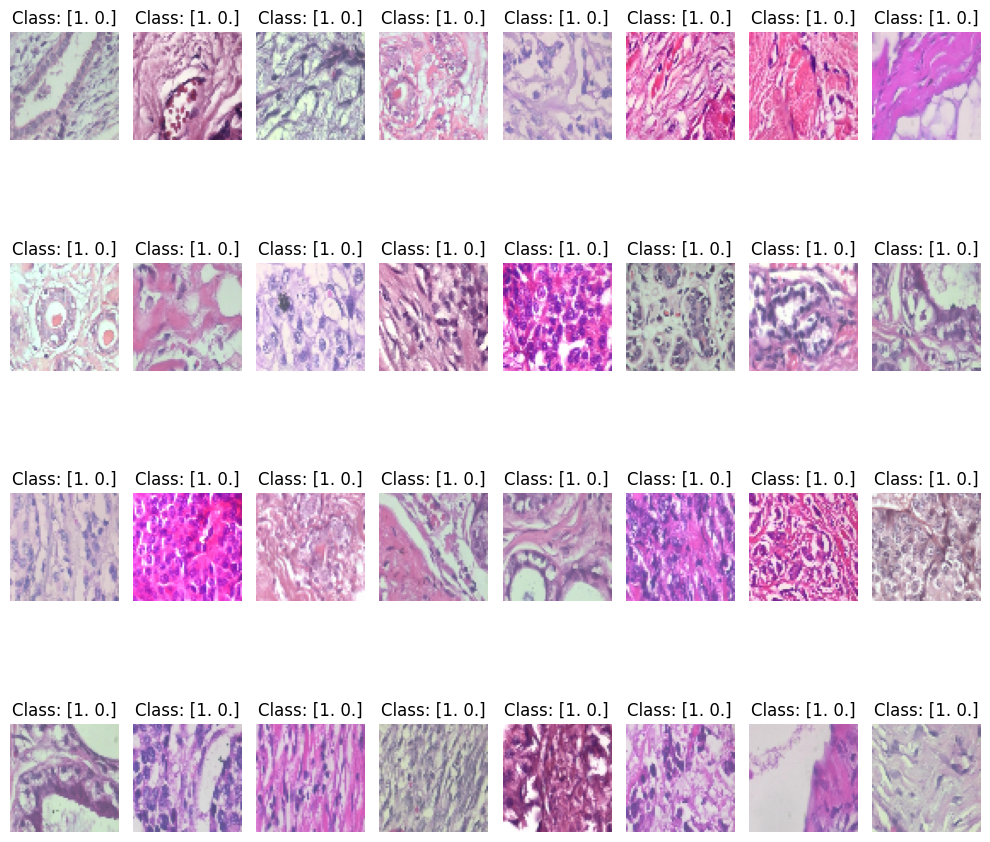

In [5]:
for i, (images, labels) in enumerate(train_dataset): #enumerate will give a tuple that consist of a count and the corresponding value
    #here i = count index on the batch, value = the_dataset values which is a tuple containing images data and labels classification
    if i == 0: #sets the index of the batch selected
        plt.figure(figsize = (10, 10))
        for p in range(len(images)): #iterate through the count of images to plot
            plt.subplot(4, 8, p+1) #(nrows, ncols, index)
            #required conversion of tensor data -> numpy array for compatibility with matplotlib
            plt.imshow(images[p].numpy().astype("uint8")) #use .astype("uint8") here because it was not yet scaled. It will make the figure plottable
            plt.title(f"Class: {labels[i].numpy()}")
            plt.axis('off')  # Turn off axis labels
        plt.tight_layout() #No overlap of graphs
        plt.show()

### Validation Set

In [6]:
# Load the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path, 
    labels = 'inferred',
    label_mode ='categorical',
    color_mode='rgb',
    image_size = (64, 64),
    batch_size = 32,
    seed = 100,
    validation_split = 0.2,
    subset = 'validation')

Found 1148 files belonging to 2 classes.
Using 229 files for validation.


## Part 2 - Preprocessing and Augmentation 
Augmentation avoids overfitting the training data.
Apply Augmentation to training set only. Applying only to the training set avoids overfitting.
Transformations are geometric transformations, rotate images, zoom in/out, flip images, etc. This is called augmentation
Augmentation can be applied to the dataset at 1 of 2 different points

Option 1) The Preprocessing Step prior to CNN model (Easier Modularity and Maintenance) (Done Here)

Option 2) Included in the actual CNN model (Easier Deployment)

### Augmentation

In [7]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation

Augmentation = tf.keras.models.Sequential([   
    Rescaling(1.0 / 255), #Rescales the pixel values so that all numbers are between 0 and 1
    RandomFlip("horizontal"), #Randomly Flips image
    RandomRotation(factor=0.2) #Rotates Images
])

train_dataset = train_dataset.map(lambda x, y: (Augmentation(x, training = True), y))
# (x, y) = (images, image labels), training = flag to indicate augmentation should be applied during training
# lambda as always is an anonymous function

### Verifying Image Augmentation
NOTES: To Verify Image Augmentation is occuring you must set shuffle = false in original dataset, otherwise the set of images will be reshuffled, this is an inherent property of tensorflow

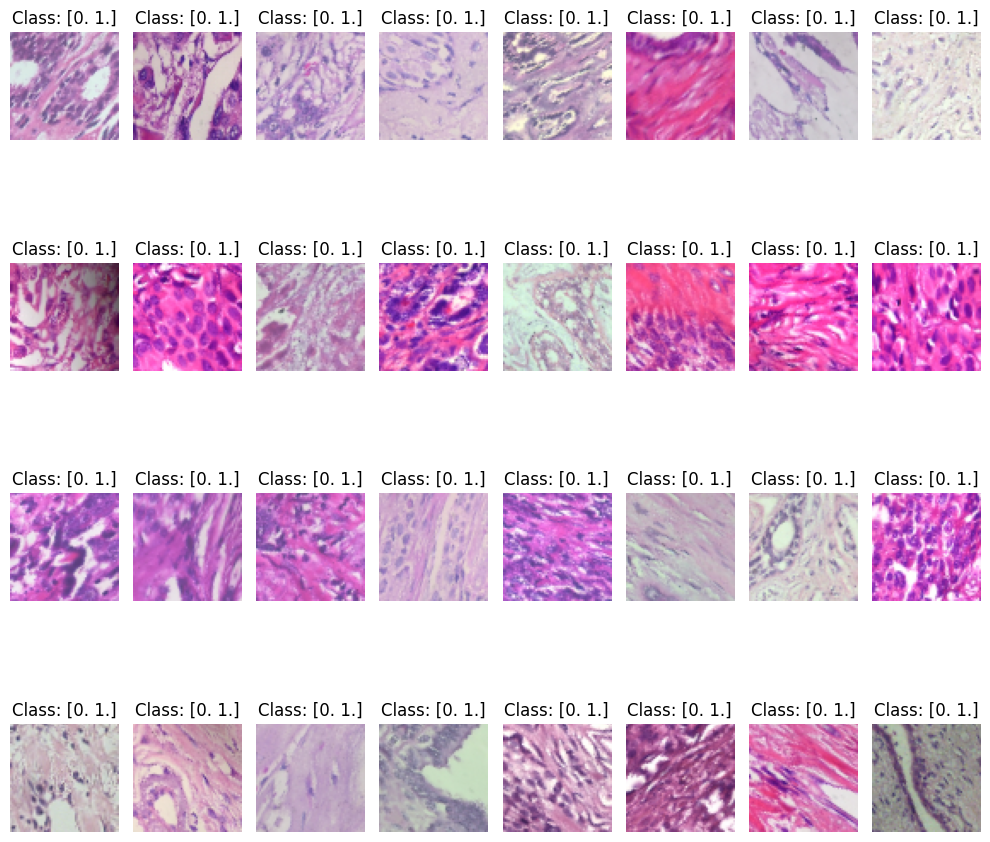

In [8]:
#prior to running the code ensure shuffle = false during the data upload
for i, (images, labels) in enumerate(train_dataset): #enumerate will give a tuple that consist of a count and the corresponding value
    #here i = batch, value = the_dataset values which is a tuple containing images data and labels classification
    if i == 0: #sets the batch
        plt.figure(figsize = (10, 10))
        for p in range(len(images)): #iterate through the count of images to plot
            plt.subplot(4, 8, p+1) #(nrows, ncols, index)
            #required conversion of tensor data -> numpy array for compatibility with matplotlib
            plt.imshow(images[p].numpy()) #do not use .astype("uint8") here because it was 1/255 scaled. It will make the figure uninterpretable
            plt.title(f"Class: {labels[i].numpy()}")
            plt.axis('off')  # Turn off axis labels
        plt.tight_layout() #No overlap of graphs
        plt.show()

### Rescaling Validation DataSet

In [9]:
Rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
validation_dataset = validation_dataset.map(lambda x, y: (Rescale(x, training = False), y))

## Part 3 - Building the CNN

### Initializing the CNN

In [10]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [11]:
# First Layer
cnn.add(tf.keras.layers.Conv2D( #add function applies new layer
    filters = 32, # Number of features
    kernel_size = 3, # Dimensions of feature detector (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)  
    activation = 'relu', # Activation type 
    input_shape = (64, 64, 3))) # Tuple that selects image properties (batch size(optional), size, size, 3(RGB) or 1(B&W))

### Step 2 - Pooling

In [12]:
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, # frame size of the pool (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)  
    strides = 2, # pixels the frame will move over when pooling (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)
    padding = 'valid'))

### Adding a second convolutional layer (Optional)

In [13]:
# cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2,padding='valid'))

### Step 3 - Flattening

In [14]:
# Flattening - Converts the data into 1D array
cnn.add(tf.keras.layers.Flatten())
#automatically flattens prior to CNN

### Step 4 - Full Connection

In [15]:
# Connect the Layers
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
# units = the number of neurons for this layer (higher usually means more accuracy)

### Step 5 - Output Layer

In [16]:
# Output Layer - Final Layer To Predict Classification
cnn.add(tf.keras.layers.Dense(units = 2, activation='softmax'))
# set the number of neurons for final classification output, binary (units = 1) vs for multiclass/categorical (units = number of categories)
#activation will be sigmoid for binary (units = 1), for multiclass(categorical) could softmax

In [17]:
#shortened summarized version of Steps 1-5
# cnn = tf.keras.models.Sequential([
#    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(image_height, image_width, channels)),
#    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
#    tf.keras.layers.Flatten(), #last layer before moving data to neural network
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(2, activation='softmax')
# ])

### Step 6 - Compile The CNN

In [18]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#compiles the cnn to the optimizer and loss function using accuracy as the metric

#Generate the model summary
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3937538 (15.02 MB)
Trainable params: 3937538 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
______________

## Part 3 - Training the CNN

### Training the CNN on the Training set and evaluating it on the Validation Set

In [19]:
cnn.fit(x = train_dataset, validation_data = validation_dataset, epochs = 15)
#trains the cnn
#need to look closer into model.fit() parameters and why we use validation_data and not a y value

#loss and accuracy = training data
#val_loss and val_accuracy = validation data
#lower loss is better

Epoch 1/15
29/29 [==============================] - 8s 231ms/step - loss: 1.0342 - accuracy: 0.6170 - val_loss: 0.4693 - val_accuracy: 0.8734
Epoch 2/15
29/29 [==============================] - 5s 152ms/step - loss: 0.4905 - accuracy: 0.7943 - val_loss: 0.3950 - val_accuracy: 0.8690
Epoch 3/15
29/29 [==============================] - 5s 152ms/step - loss: 0.5165 - accuracy: 0.7563 - val_loss: 0.3954 - val_accuracy: 0.8734
Epoch 4/15
29/29 [==============================] - 5s 151ms/step - loss: 0.4622 - accuracy: 0.8150 - val_loss: 0.3652 - val_accuracy: 0.8865
Epoch 5/15
29/29 [==============================] - 5s 151ms/step - loss: 0.4549 - accuracy: 0.8248 - val_loss: 0.3557 - val_accuracy: 0.8821
Epoch 6/15
29/29 [==============================] - 5s 151ms/step - loss: 0.4418 - accuracy: 0.8313 - val_loss: 0.4084 - val_accuracy: 0.8253
Epoch 7/15
29/29 [==============================] - 5s 150ms/step - loss: 0.4431 - accuracy: 0.8281 - val_loss: 0.3620 - val_accuracy: 0.8603
Epoch 

## Part 4 - Evaluate The Model

In [45]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/test', #file path
    labels = 'inferred',  #Automatically infer labels from directory structure (folder names)
    label_mode = 'categorical',  #Categorical/int/etc.
    color_mode='rgb', #Sets the color of the images rgb/grayscale
    image_size = (64, 64), #Image size for resizing
    batch_size = 9,  #Number must be included if the CNN model has a batch size shapes need to match (Batch, height, width, rgb)
    shuffle = False,
    validation_split = None,  #Dataset Split for training and validation sets
    subset = None)  #Specify training/validation set

test_dataset = test_dataset.map(lambda x, y: (Rescale(x, training = False), y))

Found 545 files belonging to 2 classes.


In [38]:
PredictProb = cnn.predict(test_dataset)
print(PredictProb) #Provides an array where the numbers indicate the probability of it being that particular class

61/61 [==============================] - 1s 20ms/step
[[0.8582938  0.14170626]
 [0.73530895 0.26469108]
 [0.623331   0.37666896]
 ...
 [0.45047674 0.5495233 ]
 [0.17012858 0.8298715 ]
 [0.28643188 0.7135681 ]]


In [24]:
PredictClass = (PredictProb >= 0.5).astype(int) #set the threshold as 0.5
PredictClass[0:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [26]:
for i in range(5):
    if PredictClass[i][0] == 1: #result 1st slot as batch dimension so we run result[0] to enter the batch the next [0] selects the element in the batch(the single dog image) 
        prediction = 'benign'
    elif PredictClass[i][1] == 1:    
        prediction = 'malignant'
    else:
        prediction = 'Error'
    print(prediction)

benign
benign
benign
benign
benign


# TensorFlow dataset image format
The shape of the data in a tensor flow dataset generated consists of a tuple (images, labels)  
The images are generally setup to have pixel (height, width, rgb) in an array like format
If we iterate through the image we will get the first column = height that will give each row = width with a number of columns based on rgb or bw 
example a 5x4x3 image will give an multi dimensional array that has a format of: 5 columns(height) with 4 rows(width) but at each position would have 3 columns that indicate RGB values. 

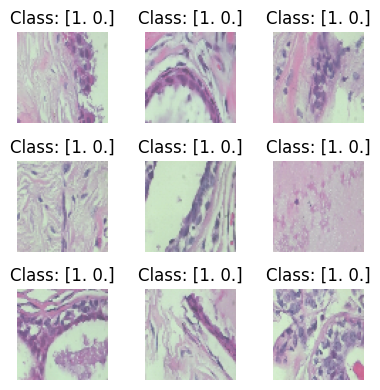

In [41]:
#for batched image set
for images, labels in test_dataset:
    plt.figure(figsize = (4, 4))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1) # (nrows, ncols, index)
        #required conversion of tensor data -> numpy array for compatibility with matplotlib 
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis('off')  # Turn off axis labels
    plt.tight_layout() # No overlap of graphs
    plt.show()
    break

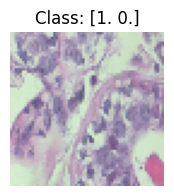

In [44]:
#for single image
for i, (images, labels) in enumerate(test_dataset): #enumerate will give a tuple that consist of a count and the corresponding value
    #here i = batch, value = the_dataset values which is a tuple containing images data and labels classification
    if i == 0: #sets the batch
        plt.figure(figsize = (2, 2))
        plt.imshow(images[8].numpy()) # uint8 ciritical for proper display if unscaled to 1/255 (Very IMPORTANT)
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis('off')  # Turn off axis labels
        #plt.tight_layout() # No overlap of graphs
        plt.show()

1/1 [==============================] - 0s 29ms/step
[[0.31404322 0.6859568 ]]
[[0 1]]
malignant


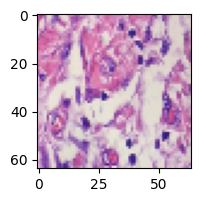

In [103]:
#test a single image of my user selection
test_image = tf.keras.utils.load_img('P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/test/malignant/SOB_M_DC-14-10926-400-005.png', target_size = (64, 64))
test_image = tf.keras.utils.img_to_array(test_image) #changes to an array so the cnn model can analyze
test_image /= 255
plt.figure(figsize = (2, 2))
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis = 0) #adds an extra dimension to enable the image to have the batch dimension
#batch dimension required because the model has to run at a certain batch number, in this example 32
#dimension of batch is added to the 1st dimension
#we can now run the predict method
result = cnn.predict(test_image)
print (result)
PredictClass = (result >= 0.5).astype(int)
print (PredictClass)

if np.all(PredictClass == np.array([1, 0])):
    print('benign')
elif np.all(PredictClass == np.array([0, 1])):
    print('malignant')
else:
    print('Error')
